# SUP ML 2 - MODEL

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer

from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import shap
from sklearn.tree import export_graphviz
import graphviz


# Functions

## Función para identificar las columnas no binarias (f1)

In [2]:
# Función para identificar las columnas no binarias
def encontrar_columnas_no_binarias(df):
    # Lista para almacenar las columnas no binarias
    columnas_no_binarias = []

    # Iterar sobre cada columna en el DataFrame
    for col in df.columns:
        # Obtener los valores únicos de la columna
        valores_unicos = df[col].unique()

        # Verificar si la columna no es binaria (es decir, no contiene solo los valores {0, 1})
        if not set(valores_unicos).issubset({0, 1}):
            columnas_no_binarias.append(col)

    return columnas_no_binarias

## Funcion para visualizar las variables numericas con histograma (f2)

In [3]:
# Funcion para visualizar las variables numericas con histograma
def visualizar_variables_numericas_hist(df, numerical_columns, num_cols=4, bins=15):

    # Calcular el número de filas necesarias
    num_rows = len(numerical_columns) // num_cols + (len(numerical_columns) % num_cols > 0)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*2.5))
    axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

    # Generar los histogramas para cada columna numérica
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=False, bins=bins, ax=axes[i])
        axes[i].set_title(f'Histograma de {col}')
        axes[i].set_yscale('log')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')

    # Eliminar los ejes vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar diseño para evitar superposición de gráficos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

## Definir la función para calcular métricas y guardar los resultados en un DataFrame (f3)

In [4]:
# Definir la función para calcular métricas y guardar los resultados en un DataFrame
def calcular_metricas(modelo, nombre, X_test, y_test, metricas_modelos):
    # Predecir las etiquetas
    y_pred = modelo.predict(X_test)

    # Calcular las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Para roc_auc_score, hay que predecir probabilidades
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = "N/A"  # Para los modelos sin predict_proba

    # Guardar las métricas en el DataFrame
    nuevo_registro = pd.DataFrame({'modelo': [nombre],
                                   'accuracy': [accuracy],
                                   'precision': [precision],
                                   'recall': [recall],
                                   'f1_score': [f1],
                                   'roc_auc': [roc_auc]})

    metricas_modelos = pd.concat([metricas_modelos, nuevo_registro], ignore_index=True)

    # Ordenar el DataFrame por roc_auc
    metricas_modelos = metricas_modelos.sort_values(by="roc_auc", ascending=False)

    return metricas_modelos

# Carga clean data

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
# Cargar el DataFrame desde el archivo pickle
df = pd.read_pickle('df_clean.pkl')
df_predecir = pd.read_pickle('df_clean_predecir.pkl')

In [7]:
# Verificar DataFrame de TrainTest
df.head(2)

,crclscod_AA,dwllsize_A,dwllsize_Unknown,ethnic_N,marital_M,marital_U,ownrent_O,dwlltype_S,dwlltype_Unknown,prizm_social_one_S,creditcd_Y,HHstatin_C,HHstatin_Unknown,dualband_Y,new_cell_U,hnd_webcap_WCMB,rev,mou,totmrc,da,vceovr,roam,change_mou,change_rev,drop_vce,blck_vce,unan_vce,recv_vce,custcare,ccrndmou,threeway,mou_cvce,mou_rvce,owylis_vce,mouowylisv,iwylis_vce,mouiwylisv,peak_vce,mou_peav,opk_vce,mou_opkv,drop_blk,complete,callwait,months,uniqsubs,actvsubs,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3qty,avg6rev,hnd_price,phones,models,lor,adults,income,numbcars,eqpdays,Customer_ID,churn
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,23.9975,219.25,22.500,0.2475,0.0,0.0,-157.25,-18.9975,0.666667,0.666667,6.333333,42.333333,0.000000,0.000000,0.000000,90.643333,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,132.600000,24.0,55.220000,1.333333,45.000000,0.333333,61,2.0,1.0,1453.44,4085.0,1602,29.66,83.37,32.69,116,38.0,149.98999,2.0,2.0,15.0,1.0,4.0,3.0,361.0,1000001,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,57.4925,482.75,37.425,0.2475,9.1,0.0,532.25,50.9875,8.333333,1.000000,61.333333,69.000000,1.666667,6.333333,0.333333,189.396667,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,75.333333,157.0,169.343333,9.333333,193.333333,5.666667,56,1.0,1.0,2833.88,26367.0,14624,51.53,479.40,265.89,158,48.0,99.98999,7.0,6.0,1.0,1.0,5.0,1.0,240.0,1000002,0


# Split X-y

In [8]:
# Separamos datos de entrenamiento y de test de target "churn"
y=df["churn"]
X=df.drop(columns=["Customer_ID","churn"])
X_predecir=df_predecir.drop(columns=["Customer_ID"])

# Distribución del target

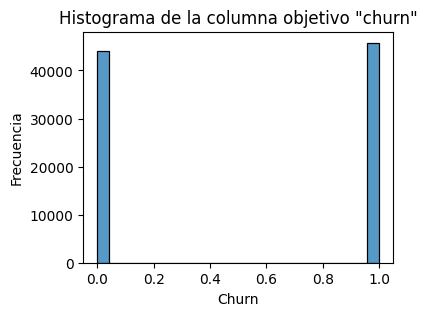

In [9]:
# Histograma de columna objetivo "churn"
plt.figure(figsize=(4,3))
sns.histplot(y)
plt.title('Histograma de la columna objetivo "churn"')
plt.ylabel("Frecuencia")
plt.xlabel("Churn")
plt.show()

In [10]:
# Calcular la distribución de la variable "churn" en porcentajes
print("Distribucion de churn (%):")
round(df["churn"].value_counts(normalize=True, dropna=False).mul(100),1)

Distribucion de churn (%):


churn
1    50.9
0    49.1
Name: proportion, dtype: float64

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

La distribución de la variable 'churn' muestra que el 50.9% de los clientes se han dado de baja (churn = 1) mientras que el 49.1% han permanecido (churn = 0). Por lo tanto, el dataset presenta un buen equilibrio entre ambas clases.

# Split TRAIN-TEST

In [11]:
# Separamos los datos en el conjunto de Train y de Test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y, random_state=8)

# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [12]:
# Identificar las columnas no binarias
columnas_no_binarias=encontrar_columnas_no_binarias(X_train) # f1

Analizamos cómo están distribuidas las variables no binarias para decidir qué tipo de Scaler utilizar

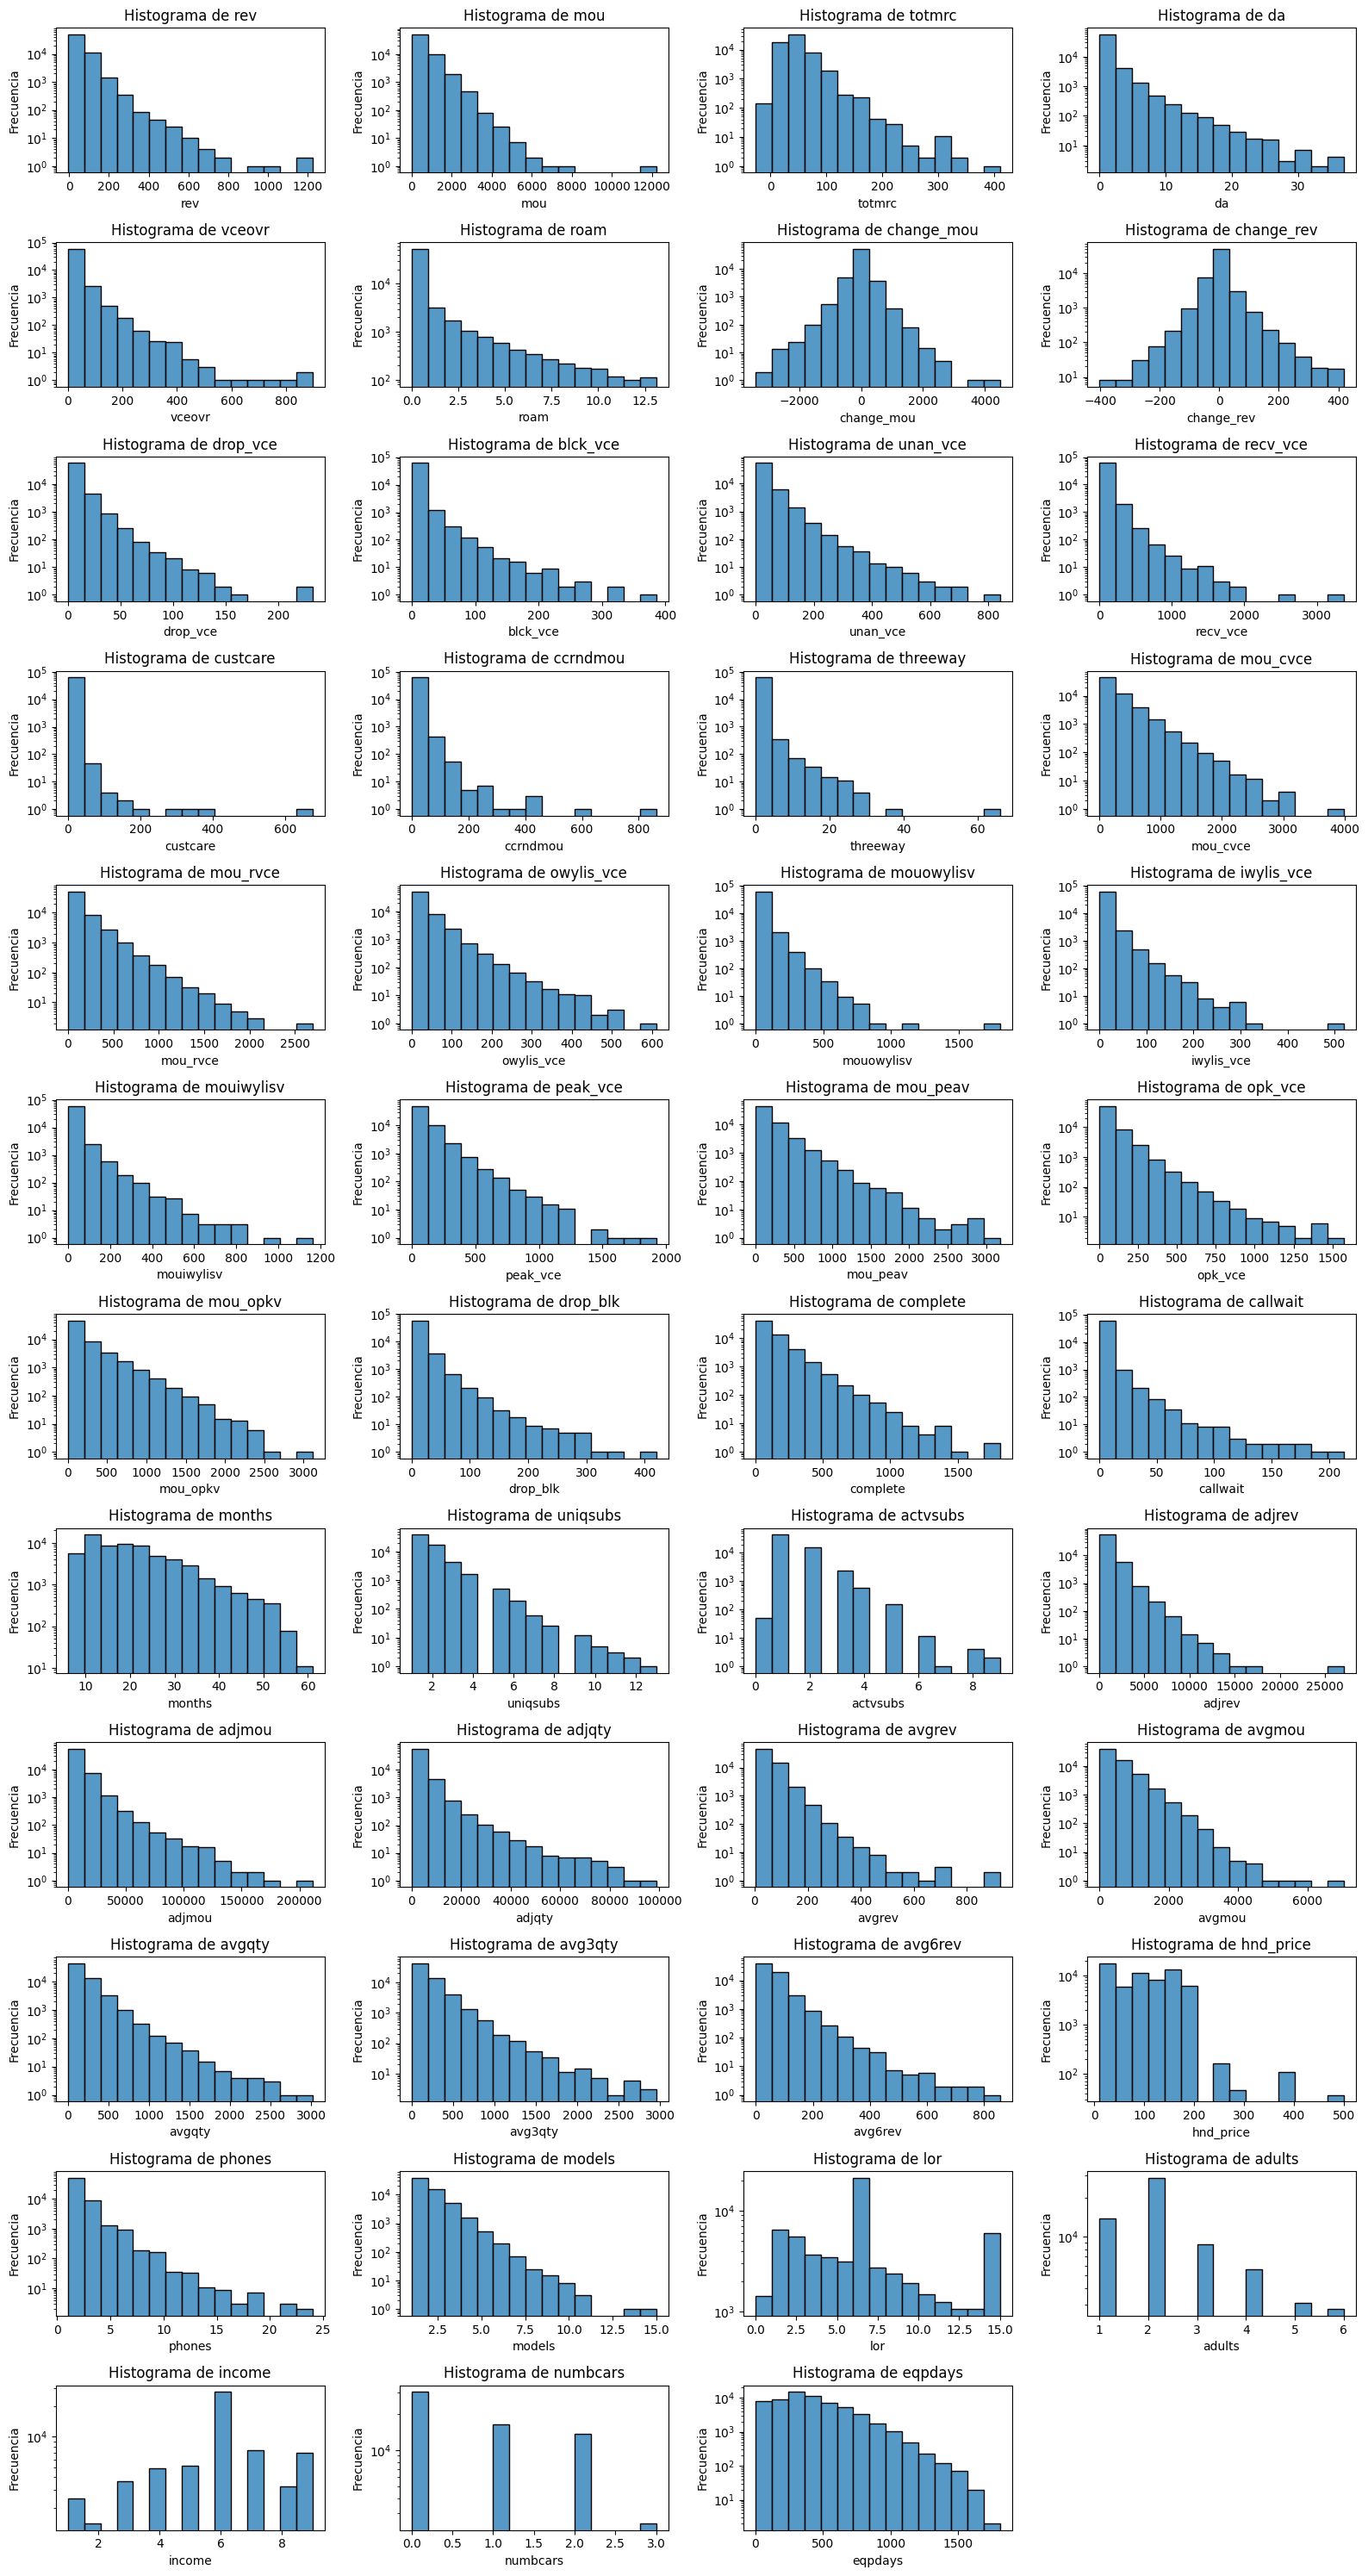

In [13]:
# Visualizar variables no binarias
visualizar_variables_numericas_hist(X_train, columnas_no_binarias) # f2

Debido a la forma de las distribuciones y al número de valores únicos, podemos agrupar las variables no binarias en 2 tipos de categorías para tratarlas con StandardScaler y MinMaxScaler

In [14]:
# Crear listas de columnas para diferentes Scalers
lista_standard=["actvsubs","totmrc","adults","income","months","change_mou","change_rev","hnd_price","lor","eqpdays"]
lista_minmax = list(set(columnas_no_binarias) - set(lista_standard))

In [15]:
# Comprobar que las listas en su conjunto suman la de valores no binarios
assert len(columnas_no_binarias)==(len(lista_minmax)+len(lista_standard))

In [16]:
# Definir Scaler con ColumnTransformer
scaler=ColumnTransformer(
    transformers=[
        ("standard",StandardScaler(),lista_standard),
        ("MinMax", MinMaxScaler(),lista_minmax)
    ],remainder="passthrough"
)

In [17]:
# Ajustar el scaler con los datos de entrenamiento
scaler.fit(X_train)

# Guardar el scaler en un archivo con pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [18]:
#Transformar los datasets de Train y Test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de validacion.

In [19]:
# Definir la lista de modelos
modelos = [
    ('RandomForest', RandomForestClassifier()),
    ('ExtraTrees', ExtraTreesClassifier()),
    ('LogisticRegression Ridge', LogisticRegression(penalty='l2', solver='lbfgs')),
    ('LogisticRegression Lasso', LogisticRegression(penalty='l1', solver='saga')),
    ('LGBMClassifier', LGBMClassifier()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=0)),
    ('XGBClassifier', XGBClassifier()),
    ('NaiveBayes', GaussianNB())
]

In [20]:
# Iterar sobre los modelos y calcular las métricas para cada uno
metricas_modelos = pd.DataFrame(columns=['modelo', 'accuracy','precision','recall','f1_score','roc_auc'])
for nombre, modelo in modelos:
    # Entrenar el modelo
    modelo.fit(X_train_scaled, y_train)

    # Hacer la predicción sobre el dataset de test y calcular las metricas
    metricas_modelos = calcular_metricas(modelo, nombre, X_test_scaled, y_test, metricas_modelos) # f3

  File "C:\Users\miros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 32034, number of negative: 30893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9069
[LightGBM] [Info] Number of data points in the train set: 62927, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509066 -> initscore=0.036268
[LightGBM] [Info] Start training from score 0.036268


In [21]:
# Mostrar los resultados del torneo de modelos
metricas_modelos

,modelo,accuracy,precision,recall,f1_score,roc_auc
0,CatBoostClassifier,0.633593,0.633216,0.665963,0.649176,0.682832
1,LGBMClassifier,0.627846,0.626179,0.667274,0.646074,0.677460
2,XGBClassifier,0.616722,0.618601,0.644330,0.631203,0.663256
3,RandomForest,0.609900,0.612593,0.635662,0.623914,0.656324
4,ExtraTrees,0.582425,0.590280,0.587443,0.588858,0.617613
5,LogisticRegression Lasso,0.582202,0.582678,0.631656,0.606179,0.611703
6,LogisticRegression Ridge,0.581646,0.582435,0.629398,0.605006,0.611109
7,NaiveBayes,0.524286,0.520778,0.820599,0.637181,0.562090


El CatBoostClassifier es el mejor modelo porque mostró el mejor desempeño en términos de ROC-AUC, lo que sugiere que es el modelo que mejor distingue entre las clases

## Hiperparametrizacion

In [171]:
# Definir el espacio de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'iterations': [850,900],                     # Número de iteraciones del modelo
    'depth': [6],                               # Profundidad de los árboles de decisión
    'learning_rate': [0.03],                 # Tasa de aprendizaje
    'l2_leaf_reg': [16],                     # Regularización L2
    'random_strength': [12],                 # Controla la aleatoriedad en las divisiones
    'border_count': [254],                         # Número de divisiones para las características continuas
    'early_stopping_rounds':[100],  # Aplicar early stopping después de 100 iteraciones sin mejoras
    'bagging_temperature':[2,3]
}

{'random_strength': 12, 'learning_rate': 0.03, 'l2_leaf_reg': 16, 'iterations': 900, 'early_stopping_rounds': 100, 'depth': 6, 'border_count': 254, 'bagging_temperature': 2}

In [172]:
# Instanciar nuevo modelo de Catboost
catboost_model=CatBoostClassifier(verbose=0)

In [173]:
# Definir el RandomizedSearchCV con 'roc_auc' como métrica para un modelo de categorias sin procesar
random_search= RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,           # Espacio de hiperparámetros
    n_iter=10,                                # Número de iteraciones a probar
    scoring='roc_auc',                        # Métrica de scoring como roc_auc
    cv=5,                                     # Validación cruzada de 5
    n_jobs=-1,                                # Usar todos los núcleos disponibles para paralelización
    verbose=1,                                # Mostrar información durante la búsqueda
    random_state=8                           # Fijar semilla para reproducibilidad
)

In [174]:
# Ajustar el RandomizedSearchCV con los datos de entrenamiento sin escalar ya que Catboost no lo precisa
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_param=random_search.best_params_
print(f"Mejores hiperparámetros encontrados:\n{best_param}")

# El mejor modelo
modelo_best= random_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros encontrados:
{'random_strength': 12, 'learning_rate': 0.03, 'l2_leaf_reg': 16, 'iterations': 900, 'early_stopping_rounds': 100, 'depth': 6, 'border_count': 254, 'bagging_temperature': 2}


# TEST

In [177]:
# Metricas para el DataSet Test
m_test=calcular_metricas(modelo_best, "Catboost best Test", X_test, y_test, pd.DataFrame()) # f3
# Metricas para el DataSet Train
m_train=calcular_metricas(modelo_best, "Catboost best Train", X_train, y_train, pd.DataFrame()) # f3
pd.concat([m_test,m_train])

,modelo,accuracy,precision,recall,f1_score,roc_auc
0,Catboost best Test,0.630701,0.628381,0.671862,0.649395,0.679567
0,Catboost best Train,0.663308,0.659576,0.699788,0.679087,0.728017


Analysis de las metricas:

1. Accuracy:

Definición: Proporción de predicciones correctas sobre el total de predicciones realizadas.

Interpretación: El accuracy en el conjunto de prueba es de aproximadamente 63%, mientras que en el conjunto de entrenamiento es del 66.25%. Esto indica que el modelo clasifica correctamente el 63% de los casos en datos no vistos y el 66.25% en los datos de entrenamiento. Una ligera diferencia como esta es esperada, ya que el modelo suele rendir mejor en los datos que ha utilizado para aprender.

2. Precision:

Definición: Proporción de verdaderos positivos sobre el total de positivos predichos. Mide la capacidad del modelo para evitar falsos positivos.

Interpretación: La precision es ligeramente más alta en el conjunto de entrenamiento (0.6591) que en el de prueba (0.6281). Esto significa que el modelo es algo más preciso al predecir positivos en los datos de entrenamiento, pero en los datos de prueba es algo menos preciso, lo que podría generar más falsos positivos en el conjunto de prueba.

3. Recall:

Definición: Proporción de verdaderos positivos sobre el total de positivos reales. Mide la capacidad del modelo para capturar los casos positivos.

Interpretación: El recall es un poco más alto en el conjunto de entrenamiento (0.6982) que en el de prueba (0.6720). Esto sugiere que el modelo captura más casos positivos en los datos de entrenamiento que en los de prueba, pero la diferencia es pequeña, lo que muestra que el modelo sigue capturando correctamente una cantidad importante de positivos en ambos conjuntos.

4. F1-Score:

Definición: Media armónica entre precision y recall, mide el balance entre ambos.

Interpretación: El f1-score es un poco más alto en el conjunto de entrenamiento (0.6781) que en el de prueba (0.6493), lo que indica un mejor equilibrio entre precisión y recall en los datos de entrenamiento. Sin embargo, la diferencia es pequeña y el modelo sigue mostrando un rendimiento equilibrado en los datos de prueba.

5. ROC AUC:

Definición: Mide la capacidad del modelo para distinguir entre las clases, cuanto más cerca de 1, mejor.

Interpretación: El ROC AUC es ligeramente mayor en los datos de entrenamiento (0.7283) que en los de prueba (0.6798), lo que indica una pequeña diferencia en la capacidad del modelo para distinguir entre las clases en ambos conjuntos. Sin embargo, la diferencia es de aproximadamente 0.0485, lo que se considera una diferencia pequeña y no significativa.



## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que han funcionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [178]:
#Entrenamos el mejor modelo sobre todo el conjunto de datos
modelo_best.fit(X,y)

Los mejores parámetros para el modelo CatBoost:

- random_strength = 12:

 Introduce más variabilidad en la forma en que el modelo busca las mejores divisiones en cada árbol. Este valor más alto añade aleatoriedad al proceso, lo que ayuda al modelo a evitar ajustarse demasiado a los detalles específicos del conjunto de entrenamiento, mejorando su capacidad de generalización.

- learning_rate = 0.03: 

Este parámetro controla la velocidad a la que el modelo ajusta los pesos a medida que se agregan nuevos árboles al ensamble. Con un valor moderado de 0.03, el modelo puede aprender de manera eficiente sin comprometer la precisión ni la estabilidad durante el entrenamiento.

- l2_leaf_reg = 16: 

Este es un parámetro de regularización L2 que penaliza los pesos elevados en las hojas de los árboles. Un valor de 16 añade una regularización más fuerte, lo que reduce el riesgo de sobreajuste y ayuda al modelo a generalizar mejor en datos no vistos.

- iterations = 900: 

Con 900 iteraciones, el modelo tiene suficientes árboles para capturar patrones complejos sin volverse excesivamente costoso en términos de tiempo de entrenamiento. Esto permite al modelo mejorar su precisión manteniendo la complejidad en niveles manejables.

- early_stopping_rounds = 100: 

El entrenamiento se detendrá si no se observa mejora en la métrica de validación durante 100 iteraciones consecutivas, evitando que el modelo siga ajustándose innecesariamente a los datos de entrenamiento y reduciendo el riesgo de sobreajuste.

- depth = 6: 

Con una profundidad de 6, el modelo puede capturar interacciones complejas entre características, pero sin llegar a una profundidad que aumente el riesgo de sobreajuste significativo. Esto proporciona un buen equilibrio entre la capacidad del modelo para aprender patrones complejos y su capacidad de generalización.

- border_count = 254: 

Este valor especifica el número de divisiones o puntos de corte que se utilizarán para las características numéricas. Con 254 divisiones, el modelo es capaz de capturar diferencias sutiles en los datos, lo que mejora su precisión y capacidad para detectar patrones complejos.

- bagging_temperature = 2: 
Este parámetro controla la cantidad de aleatoriedad en el muestreo de los datos. Un valor de 2 introduce una mayor aleatoriedad en el proceso de muestreo, lo que permite una mayor diversidad entre los árboles del modelo y ayuda a reducir el riesgo de sobreajuste.



In [179]:
# Guardar el modelo entrenado en un archivo pickle
with open('modelo_best.pkl', 'wb') as archivo:
    pickle.dump(modelo_best, archivo)

# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

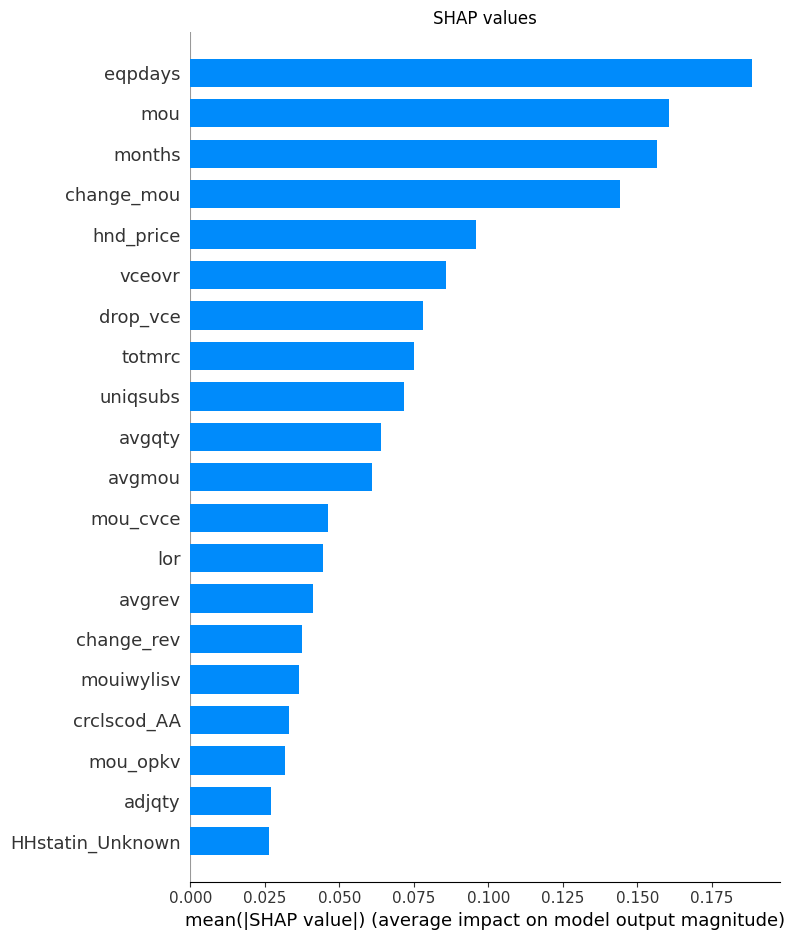

In [180]:
# Crear el explainer SHAP
explainer=shap.TreeExplainer(modelo_best)

# Calcular los valore shap para el conjunto de Test
shap_values=explainer.shap_values(X_test)

# Crear un grafico de resumen de los valores SHAP
plt.title("SHAP values")
shap.summary_plot(shap_values, X_test,plot_type="bar",max_display=20)


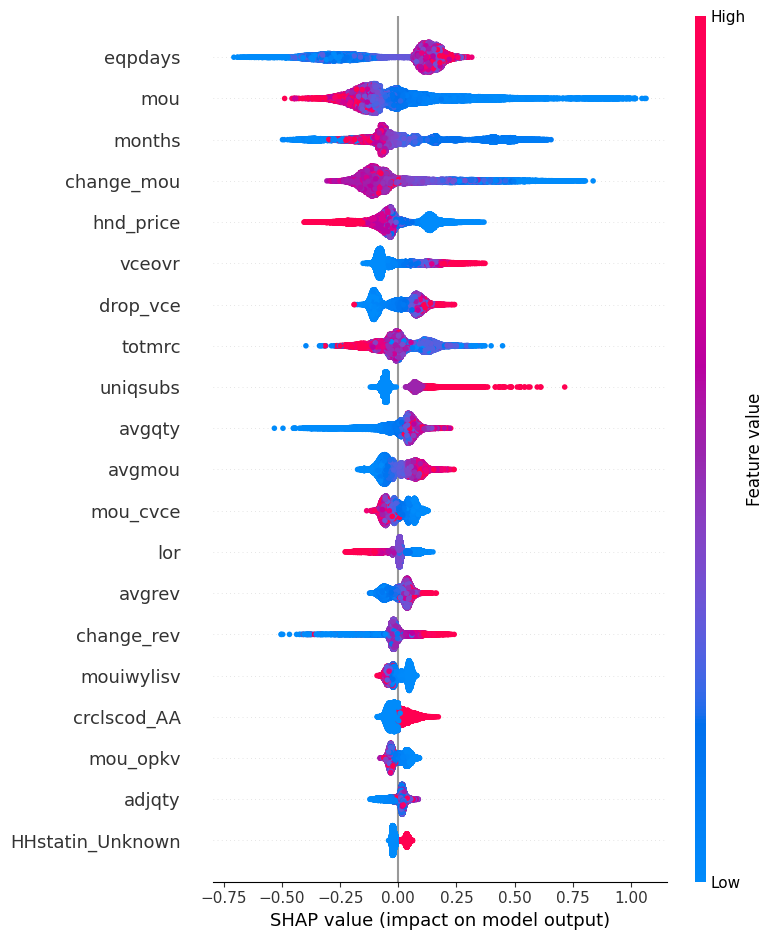

In [183]:
#Visualizamos el impacto de los parametros
shap.summary_plot(shap_values, X_test)

Analizando las primeras cinco características del gráfico:

- eqpdays (Number of days (age) of current equipment):

Interpretación: Los valores bajos de eqpdays (puntos azules) están hacia la izquierda, indicando una menor probabilidad de churn. Los valores más altos (puntos rosas) están hacia la derecha, lo que indica una mayor probabilidad de churn.

Conclusión: Los clientes que han tenido su equipo por mucho tiempo son más propensos a abandonar, mientras que aquellos que han cambiado su equipo recientemente son menos propensos a churn.

- mou (Mean number of monthly minutes of use):

Interpretación: Los puntos azules (valores bajos de minutos de uso) se encuentran hacia la derecha, lo que indica una mayor probabilidad de churn. Los puntos rosas (valores altos de minutos de uso) están hacia la izquierda, lo que indica una menor probabilidad de churn.

Conclusión: Los clientes con menor uso mensual de minutos son más propensos a churn, mientras que aquellos con un mayor uso mensual tienen menos probabilidades de abandonar.

- months (Total number of months in service):

Interpretación: Los puntos rosas (valores altos de months, es decir, clientes que llevan más tiempo en el servicio) se encuentran más hacia la izquierda, lo que sugiere que a medida que aumenta el tiempo de servicio, disminuye la probabilidad de churn. Sin embargo, los puntos azules (valores bajos de months, es decir, clientes nuevos) tienden a estar más hacia la derecha, lo que podría indicar una mayor probabilidad de churn. No obstante, también hay puntos azules hacia la izquierda, lo que sugiere que esta característica no tiene una influencia clara o consistente sobre el churn.

Conclusión: Aunque hay cierta tendencia de que los clientes que llevan más tiempo con el servicio son menos propensos a churn, los clientes nuevos muestran un comportamiento mixto, lo que sugiere que months no es un predictor fuerte del churn en comparación con otras características.

- change_mou (Percentage change in monthly minutes of use vs previous three month average):

Interpretación: Los puntos rosas (valores altos de change_mou) se encuentran más hacia la izquierda, lo que indica una menor probabilidad de churn. Los puntos azules (valores bajos de change_mou) están hacia la derecha, lo que sugiere una mayor probabilidad de churn.

Conclusión: Los clientes que experimentan grandes cambios en su uso mensual de minutos son menos propensos a abandonar, mientras que aquellos con un uso más estable o sin cambios tienen una mayor probabilidad de churn.

- hnd_price (Current handset price):

Interpretación: Los puntos rosas (valores altos de hnd_price, es decir, clientes con dispositivos más caros) se encuentran predominantemente hacia la izquierda, lo que sugiere que estos clientes son menos propensos a churn. En contraste, los puntos azules (valores bajos de hnd_price, es decir, clientes con dispositivos más baratos) se distribuyen mayoritariamente hacia la derecha, lo que indica una mayor probabilidad de churn. 

Conclusión: En general, los clientes que han comprado dispositivos más caros son menos propensos a abandonar, mientras que los que tienen dispositivos más baratos parecen tener un mayor riesgo de churn. Aunque en algunos casos, los clientes con equipos más baratos también muestran una menor probabilidad de churn, lo que sugiere que este factor puede no ser decisivo por sí solo.

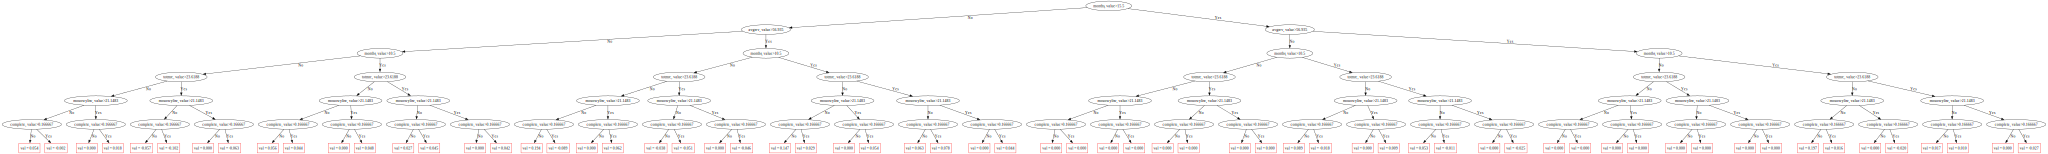

<Figure size 1200x800 with 0 Axes>

In [31]:
# Plotear el octavo Arbol de decisiones

plt.figure(figsize=(12, 8))
modelo_best.plot_tree(tree_idx=8, pool=Pool(X, y))

       Feature  Importance
44      months   11.210051
62     eqpdays    8.310150
22  change_mou    7.946737
17         mou    7.377227
18      totmrc    6.297301
55   hnd_price    4.160402
23  change_rev    4.141864
51      avgmou    2.473886
52      avgqty    2.416007
16         rev    2.377342


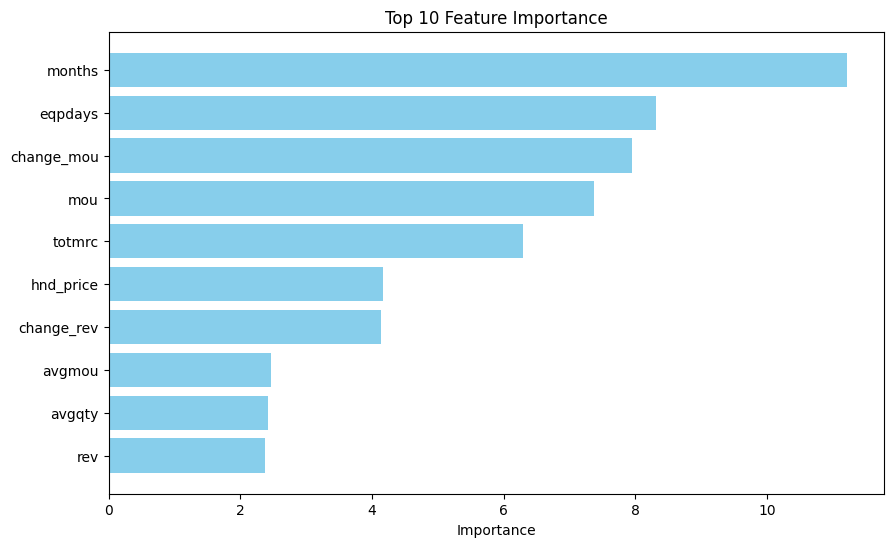

In [32]:
# Obtener la importancia de las características del modelo_best
feature_importance = modelo_best.get_feature_importance()

# Obtener los nombres de las características
feature_names = modelo_best.feature_names_

# Crear un DataFrame con las importancias de las características
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar las características por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df.head(10))

# Visualizar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Invertir el eje Y para que las características más importantes estén en la parte superior
plt.show()


Resumen de la importancia de las características (ajustado según la interpretación SHAP):

Es importante destacar que las características más importantes del modelo pueden ser mejor analizadas utilizando SHAP, ya que este enfoque permite comprender en qué dirección van las tendencias. No solo muestra la magnitud de la influencia de cada característica, sino también si están aumentando o disminuyendo la probabilidad de churn. A continuación se detalla la interpretación basada en SHAP:

1. months (Total number of months in service):

Interpretación: Aunque el modelo sugiere que esta es la característica más importante, SHAP muestra que la dirección de su impacto es más ambigua. Los clientes que han pasado menos tiempo en la compañía podrían tener más probabilidad de churn, pero no siempre es así. Algunos clientes más nuevos podrían abandonar, mientras que otros podrían quedarse, dependiendo de otros factores, como las ofertas recibidas o la percepción del servicio.

2. eqpdays (Number of days of current equipment):

Interpretación: SHAP corrobora que los equipos más antiguos incrementan significativamente la probabilidad de churn. Los clientes que han tenido el mismo dispositivo durante un largo período suelen estar insatisfechos y son más propensos a abandonar el servicio, probablemente porque perciben que necesitan una actualización o no están obteniendo suficiente valor por su equipo actual.

3. change_mou (Percentage change in monthly minutes of use vs previous three month average):

Interpretación: SHAP revela que los clientes que no cambian su uso de minutos son más propensos a churn. Esto podría indicar que aquellos con un comportamiento estable de uso pueden estar menos satisfechos, ya que no están experimentando mejoras en su plan o cambios en su servicio. En contraste, los clientes que han cambiado su uso de minutos a menudo han migrado a un nuevo plan que se adapta mejor a sus necesidades.

4. mou (Mean number of monthly minutes of use):

Interpretación: Según SHAP, los clientes que usan más minutos mensualmente están más comprometidos con el servicio y, por lo tanto, menos propensos a churn. Esto corrobora la idea de que un mayor uso del servicio está vinculado a una mayor lealtad, ya que los usuarios que dependen más del servicio tienen menos incentivos para abandonarlo.

5. totmrc (Mean total monthly recurring charge):

Interpretación: SHAP indica que los clientes que pagan menos podrían estar buscando reducir aún más sus gastos, lo que los hace más propensos a cambiarse a opciones más económicas. Esto sugiere que los clientes más sensibles al precio son más proclives a buscar ofertas alternativas, incluso si ya están pagando tarifas bajas.

6. hnd_price (Current handset price):

Interpretación: Los clientes con dispositivos más baratos son más susceptibles a cambiar de proveedor, ya que, según SHAP, estos clientes están menos comprometidos con el servicio y son más propensos a aceptar ofertas de otras compañías. Esto puede deberse a que sienten que no están vinculados a un equipo costoso y, por lo tanto, les resulta más fácil tomar la decisión de cambiar.

7. change_rev (Percentage change in monthly revenue vs previous three month average):

Interpretación: Los cambios en los ingresos mensuales pueden indicar que un cliente está reconsiderando su relación con la compañía, pero SHAP revela que esta característica no siempre es decisiva para el churn. Aunque las fluctuaciones en los ingresos pueden hacer que los clientes busquen alternativas, su impacto no es tan determinante como otros factores.

8. avgmou (Average number of monthly minutes of use):

Interpretación: SHAP predice que los clientes que usan más minutos mensualmente son más propensos a churn. Aunque en otros contextos, un mayor uso de un servicio podría estar vinculado a una mayor lealtad, SHAP muestra que, en este caso, los usuarios con un uso alto de minutos podrían estar buscando ofertas más competitivas o mejores tarifas, lo que aumenta su probabilidad de abandonar el servicio.

9. avgqty (Average quantity of services used):

Interpretación: SHAP muestra que los clientes que utilizan más servicios son más propensos a churn. A pesar de usar una mayor cantidad de servicios, estos clientes podrían estar buscando opciones más económicas o paquetes más ajustados a sus necesidades.

10. rev (Monthly revenue):

Interpretación: SHAP predice que los clientes con mayores ingresos mensuales son más propensos a churn. Estos clientes podrían sentirse insatisfechos con el valor que están recibiendo por lo que pagan, lo que los impulsa a considerar otras opciones que ofrezcan un mejor equilibrio entre costo y beneficio.